In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [3]:
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.ndimage
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.transform import resize
from scipy.ndimage import binary_dilation
from tensorflow.keras import backend as K


In [6]:
# Function to load NIfTI files with memory mapping
def load_nifti_memmap(file_path):
    img = nib.load(file_path)
    data = img.get_fdata(dtype=np.float32, caching='unchanged')  # Memory-mapped array
    affine = img.affine
    header = img.header
    return data, affine, header

# Generator function to load data in batches
def data_generator(file_list, data_path, mask_path, batch_size, target_shape=None):
    while True:
        np.random.shuffle(file_list)
        for start in range(0, len(file_list), batch_size):
            end = min(start + batch_size, len(file_list))
            batch_files = file_list[start:end]
            
            X_batch = []
            y_batch = []
            
            for filename in batch_files:
                img_path = os.path.join(data_path, filename)
                corresponding_mask_path = os.path.join(mask_path, filename)
                
                image, _, _ = load_nifti_memmap(img_path)
                mask, _, _ = load_nifti_memmap(corresponding_mask_path)
                
                # Ensure image and mask have the same shape (and possibly resize if needed)
                if target_shape:
                    image = resize_volume(image, target_shape)
                    mask = resize_volume(mask, target_shape)
                
                X_batch.append(image)
                y_batch.append(mask)
            
            X_batch = np.array(X_batch)[..., np.newaxis]  # Adding channel dimension
            y_batch = np.array(y_batch)[..., np.newaxis]  # Adding channel dimension
            
            yield X_batch, y_batch

# Function to resize volumes (if needed)
def resize_volume(img, target_shape):
    current_shape = img.shape
    if current_shape == target_shape:
        return img
    # Example: using scipy for interpolation
    resized_img = scipy.ndimage.zoom(img, (target_shape[0]/current_shape[0], target_shape[1]/current_shape[1], target_shape[2]/current_shape[2]), order=3)
    return resized_img

def resize_image(image, target_shape):
    return resize(image, target_shape, mode='reflect', anti_aliasing=True)

def pad_or_crop_volume(volume, target_shape):
    padded = np.zeros(target_shape, dtype=volume.dtype)
    slices = tuple(slice(0, min(s, d)) for s, d in zip(volume.shape, target_shape))
    padded[slices] = volume[slices]
    return padded


def calculate_volume(mask, voxel_volume):
    return np.sum(mask > 0) * voxel_volume

def unet_3d(input_shape):
    inputs = Input(input_shape)
    
    # Downsampling
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)  # Added layer
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)  # Added layer
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)  # Added layer
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)  # Added layer
    p2 = MaxPooling3D((2, 2, 2))(c2)
    
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)  # Added layer
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)  # Added layer
    
    # Upsampling
    u4 = UpSampling3D((2, 2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u4)
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c4)
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c4)  # Added layer
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c4)  # Added layer
    
    u5 = UpSampling3D((2, 2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u5)
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c5)
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c5)  # Added layer
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c5)  # Added layer
    
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
    
    model = Model(inputs, outputs)
    #model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, jaccard_index])
    return model

# Dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Jaccard index
def jaccard_index(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1)

# Boundary F1 Score
# Function to calculate boundary mask
def extract_boundary_tensor(mask, dilation_radius=1):
    """
    Extract boundaries from a binary mask using dilation and subtraction in a symbolic tensor.
    """
    # Define a 3D spherical structuring element
    kernel_size = 2 * dilation_radius + 1
    struct = tf.ones((kernel_size, kernel_size, kernel_size, 1, 1), dtype=tf.float32)

    # Expand dimensions to match 5D tensor format for 3D convolution
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension

    # Perform binary dilation and subtract the original mask to get the boundary
    dilated_mask = tf.nn.conv3d(mask, struct, strides=[1, 1, 1, 1, 1], padding="SAME")
    boundary = tf.cast(dilated_mask > 0, tf.float32) - mask
    boundary = tf.clip_by_value(boundary, 0, 1)  # Ensure binary output

    return tf.squeeze(boundary, axis=-1)  # Remove channel dimension

# Boundary F1 score metric
def boundary_f1_score(y_true, y_pred, dilation_radius=1):
    """
    Compute Boundary F1 score for predicted masks compared to true masks in symbolic tensors.
    """
    y_true_boundary = extract_boundary_tensor(y_true, dilation_radius)
    y_pred_boundary = extract_boundary_tensor(y_pred > 0.5, dilation_radius)
    
    true_positives = tf.reduce_sum(y_true_boundary * y_pred_boundary)
    false_positives = tf.reduce_sum(y_pred_boundary) - true_positives
    false_negatives = tf.reduce_sum(y_true_boundary) - true_positives
    
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1_score

# Example paths (update these to your dataset paths)
data_path = r'/home/icmr/Downloads/niigz dicom/Arterial Phase'  # Update with the correct path
mask_path = r'/home/icmr/Downloads/niigz liver/Arterial Phase'  # Update with the correct path

# Verify paths exist
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data path not found: {data_path}")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Mask path not found: {mask_path}")

# List of files
file_list = [filename for filename in os.listdir(data_path) if filename.endswith('.nii.gz')]

# Split the dataset
train_val_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_val_files, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Define and compile the model
input_shape = (128, 128, 64, 1)  # Example input shape, adjust accordingly
model = unet_3d(input_shape)
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, jaccard_index, boundary_f1_score]
)

# Define callbacks
checkpoint = ModelCheckpoint('unet3d_best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define batch size
batch_size = 2

# Create data generators
train_generator = data_generator(train_files, data_path, mask_path, batch_size, target_shape=input_shape[:3])
val_generator = data_generator(val_files, data_path, mask_path, batch_size, target_shape=input_shape[:3])
test_generator = data_generator(test_files, data_path, mask_path, batch_size, target_shape=input_shape[:3])

# Calculate steps per epoch
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size
test_steps = len(test_files) // batch_size

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=200, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[checkpoint])

# Save the model
model.save('unet3d_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy, test_dice, test_jaccard, test_boundary_f1 = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test Jaccard Index: {test_jaccard}")
print(f"Test Boundary F1 Score: {test_boundary_f1}")



2024-12-22 11:58:38.070105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43228 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:51:00.0, compute capability: 8.6


Epoch 1/200


2024-12-22 11:58:55.268261: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-12-22 11:58:55.393317: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-22 11:58:56.246154: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-22 11:59:02.974932: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d42350a5b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-22 11:59:02.974990: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-12-22 11:59:02.982226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734848943.149639  771407 device_compiler.h:186] 

6/6 [==============================] - 69s 9s/step - loss: 3.1263 - accuracy: 0.7070 - dice_coefficient: 0.0966 - jaccard_index: 0.0522 - boundary_f1_score: 0.0914 - val_loss: 0.1420 - val_accuracy: 0.6708 - val_dice_coefficient: 0.2575 - val_jaccard_index: 0.1486 - val_boundary_f1_score: 4.2887e-04
Epoch 2/200


/home/icmr/myenv_py311/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 54s 11s/step - loss: 0.1271 - accuracy: 0.7309 - dice_coefficient: 0.1567 - jaccard_index: 0.0857 - boundary_f1_score: 1.2909e-04 - val_loss: 0.1315 - val_accuracy: 0.6883 - val_dice_coefficient: 0.2560 - val_jaccard_index: 0.1468 - val_boundary_f1_score: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 53s 11s/step - loss: 0.0952 - accuracy: 0.7309 - dice_coefficient: 0.2565 - jaccard_index: 0.1475 - boundary_f1_score: 0.0000e+00 - val_loss: 0.1151 - val_accuracy: 0.6708 - val_dice_coefficient: 0.3146 - val_jaccard_index: 0.1872 - val_boundary_f1_score: 0.0000e+00
Epoch 4/200
6/6 [==============================] - 54s 11s/step - loss: 0.0878 - accuracy: 0.7309 - dice_coefficient: 0.2711 - jaccard_index: 0.1570 - boundary_f1_score: 0.0000e+00 - val_loss: 0.1272 - val_accuracy: 0.6533 - val_dice_coefficient: 0.2866 - val_jaccard_index: 0.1675 - val_boundary_f1_score: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 55s 11s

1/1 [==============================] - 0s 29ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_0.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 21ms/step
Calculated volume for Dlive

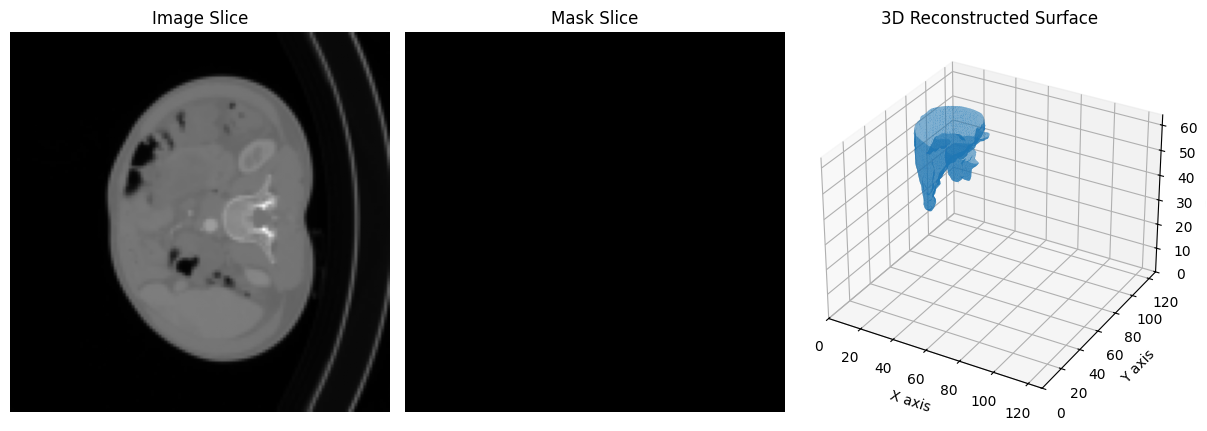

1/1 [==============================] - 0s 22ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_1.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 23ms/step
Calculated volume for Dlive

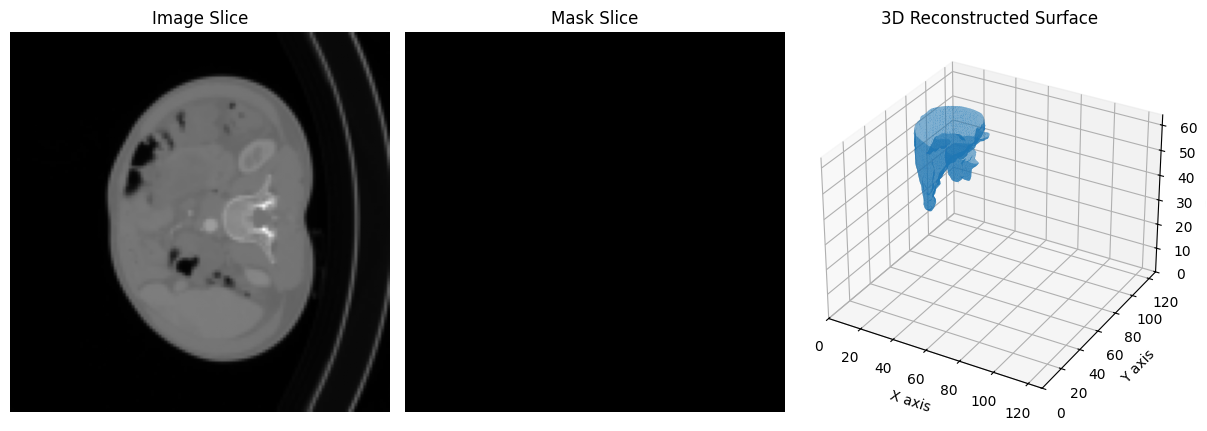

1/1 [==============================] - 0s 22ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_2.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 22ms/step
Calculated volume for Dlive

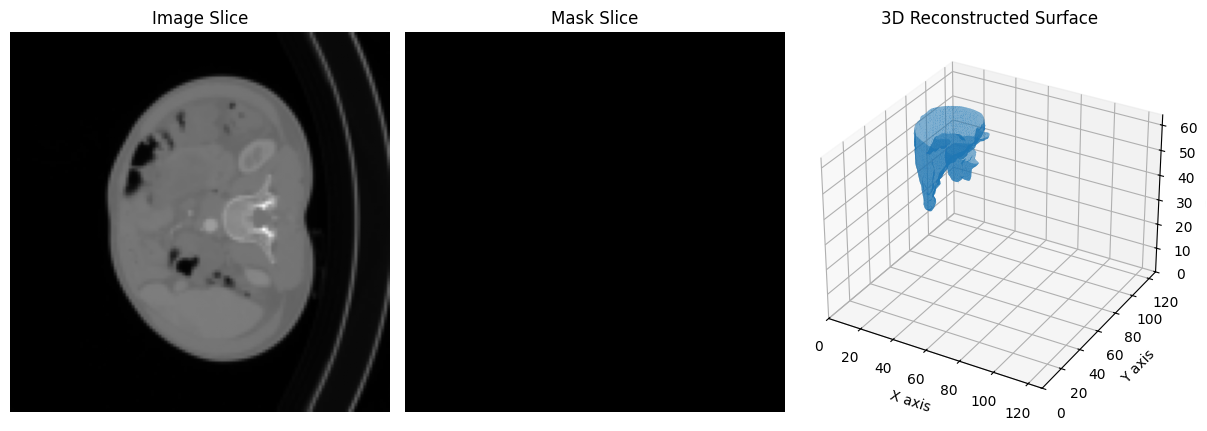

1/1 [==============================] - 0s 22ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_3.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 25ms/step
Calculated volume for Dlive

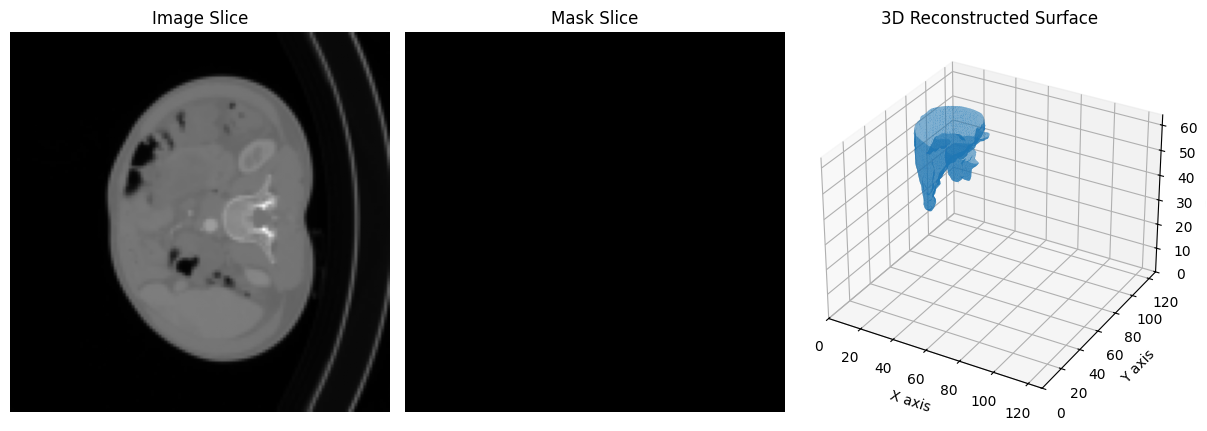

1/1 [==============================] - 0s 22ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_4.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 25ms/step
Calculated volume for Dlive

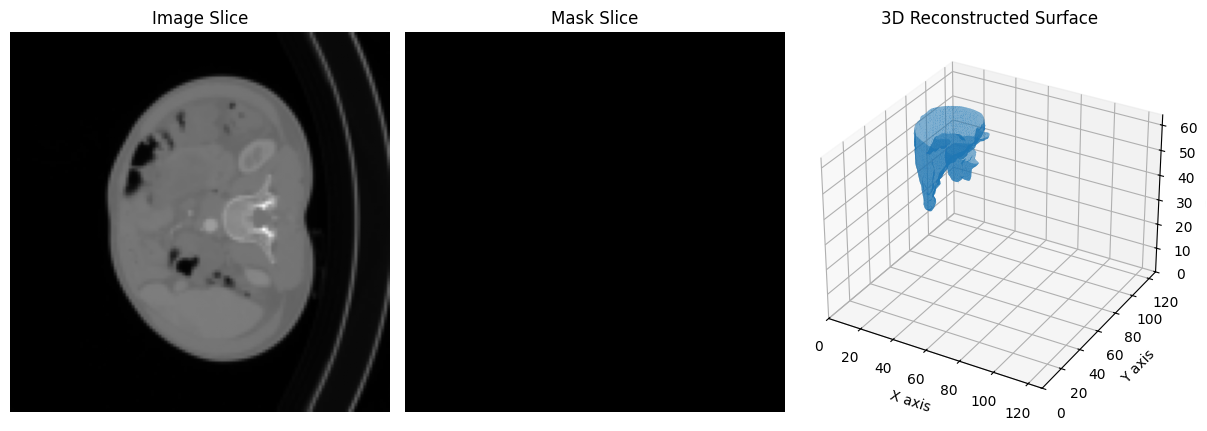

1/1 [==============================] - 0s 25ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_5.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dlive

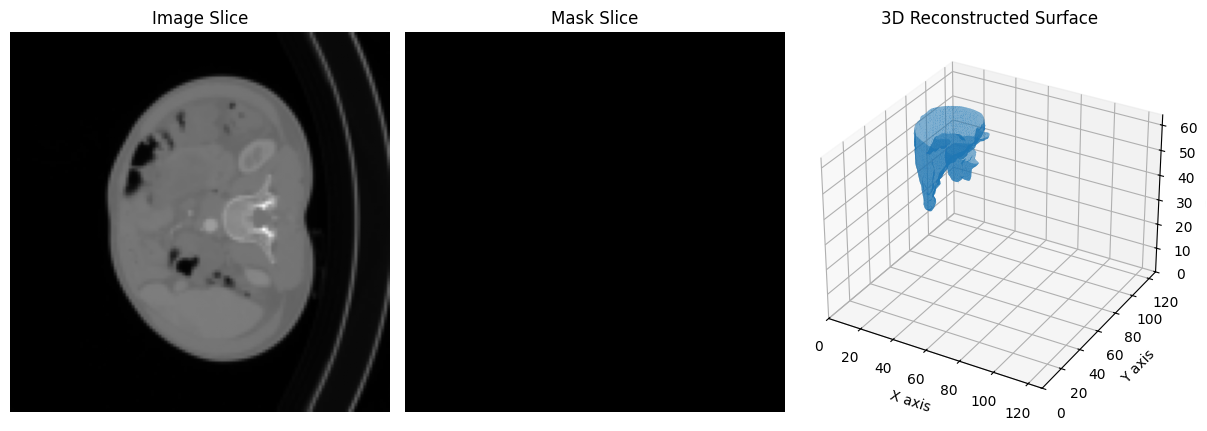

1/1 [==============================] - 0s 25ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_6.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 25ms/step
Calculated volume for Dlive

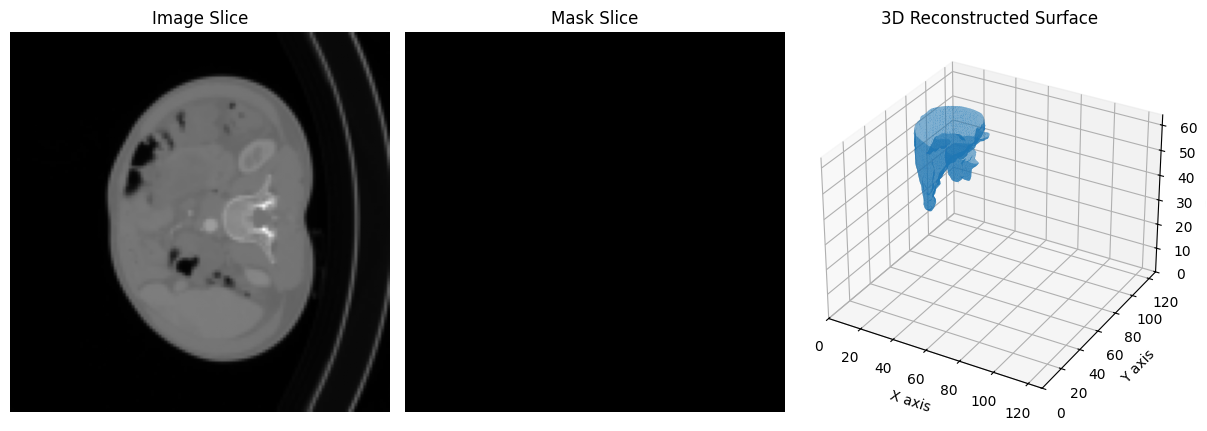

1/1 [==============================] - 0s 26ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_7.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 23ms/step
Calculated volume for Dlive

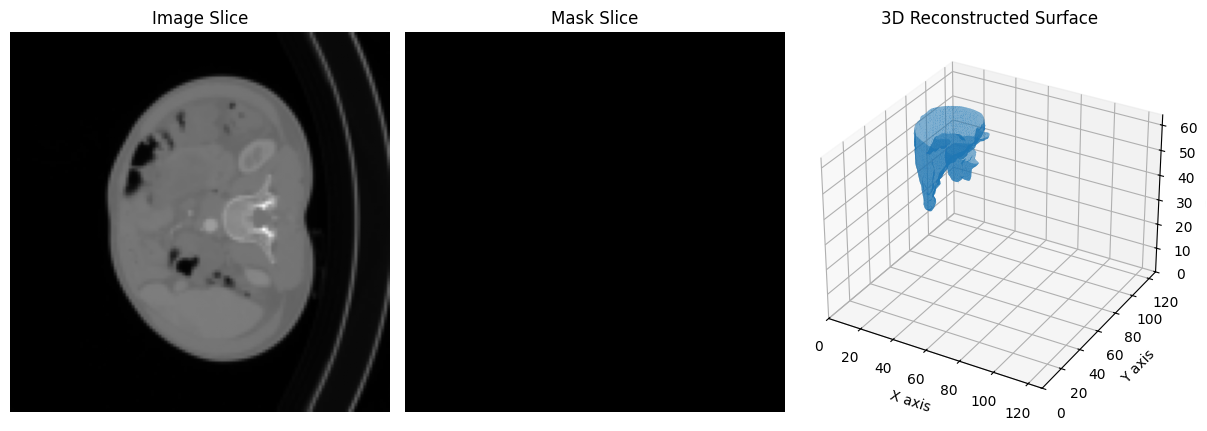

1/1 [==============================] - 0s 24ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_8.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 31ms/step
Calculated volume for Dlive

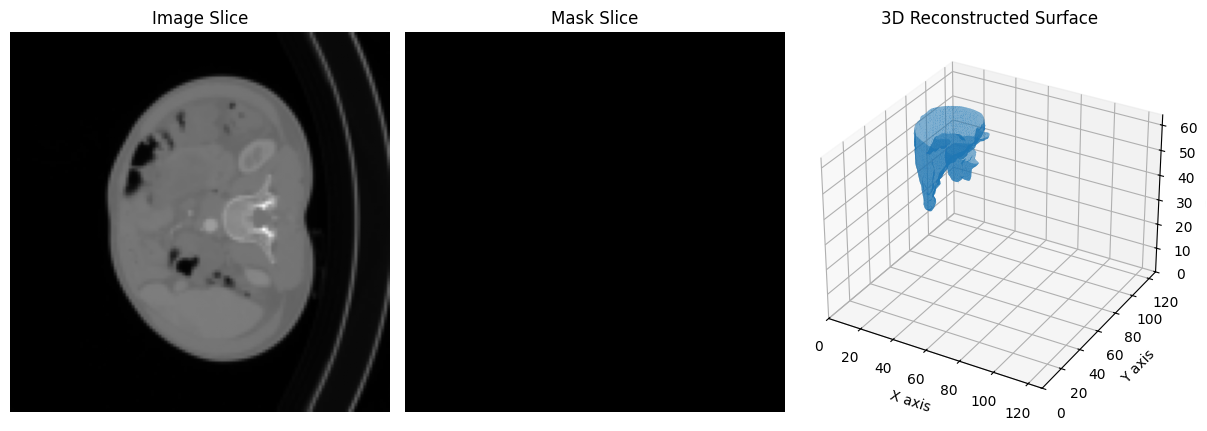

1/1 [==============================] - 0s 26ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_9.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dlive

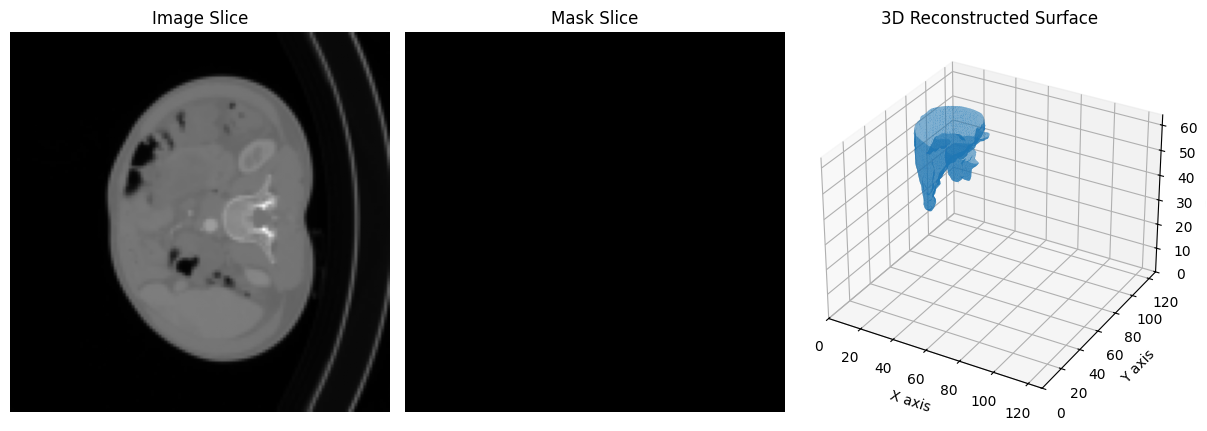

1/1 [==============================] - 0s 27ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_10.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dliv

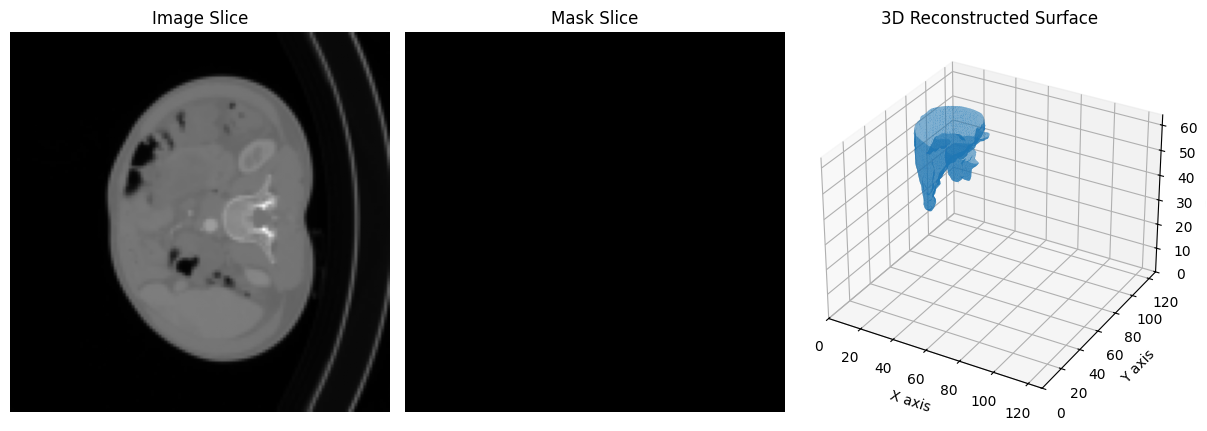

1/1 [==============================] - 0s 25ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_11.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dliv

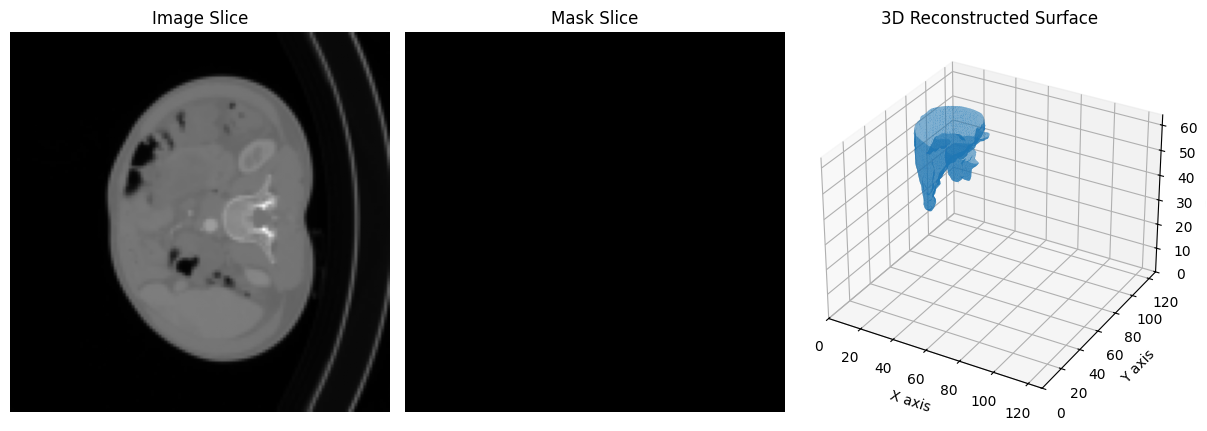

1/1 [==============================] - 0s 25ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_12.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dliv

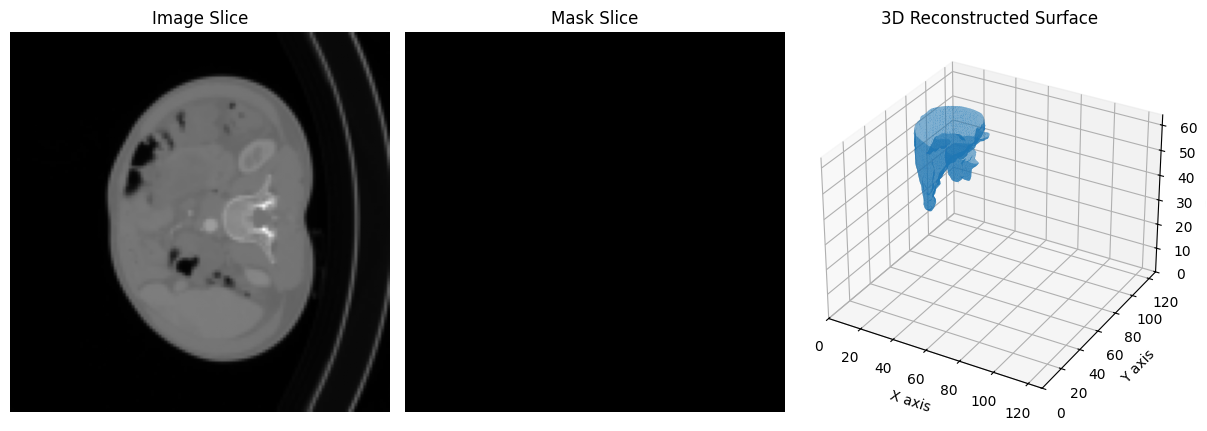

1/1 [==============================] - 0s 26ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_13.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 37ms/step
Calculated volume for Dliv

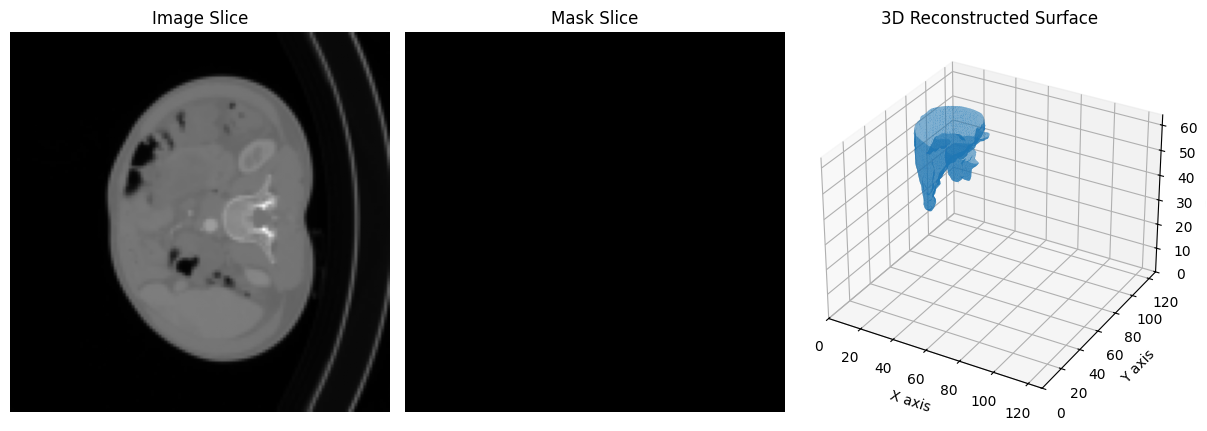

1/1 [==============================] - 0s 27ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_14.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dliv

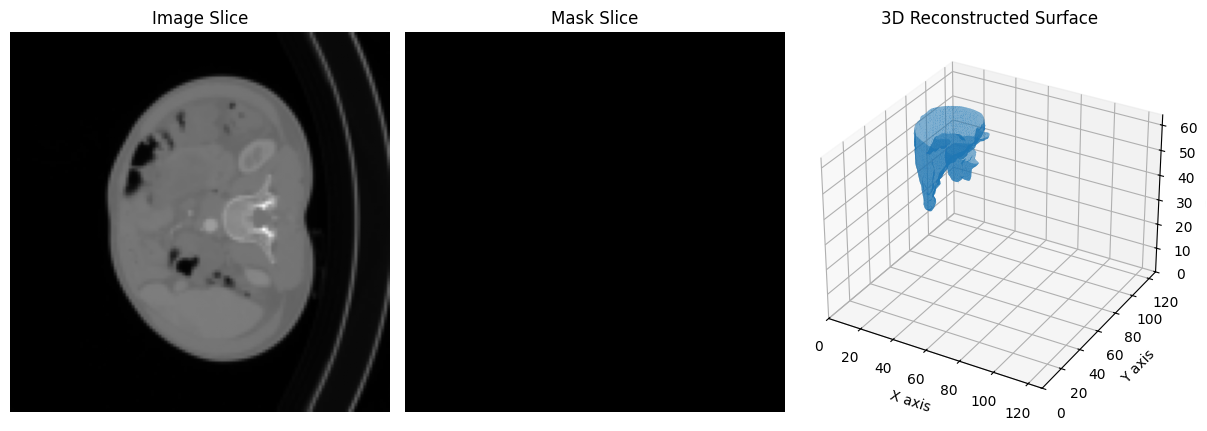

1/1 [==============================] - 0s 25ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_15.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dliv

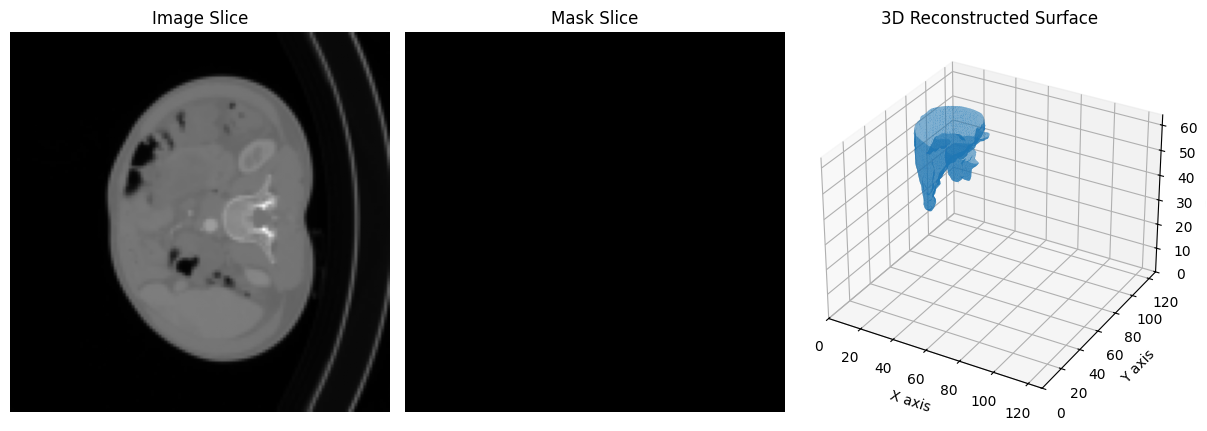

1/1 [==============================] - 0s 26ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_16.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 27ms/step
Calculated volume for Dliv

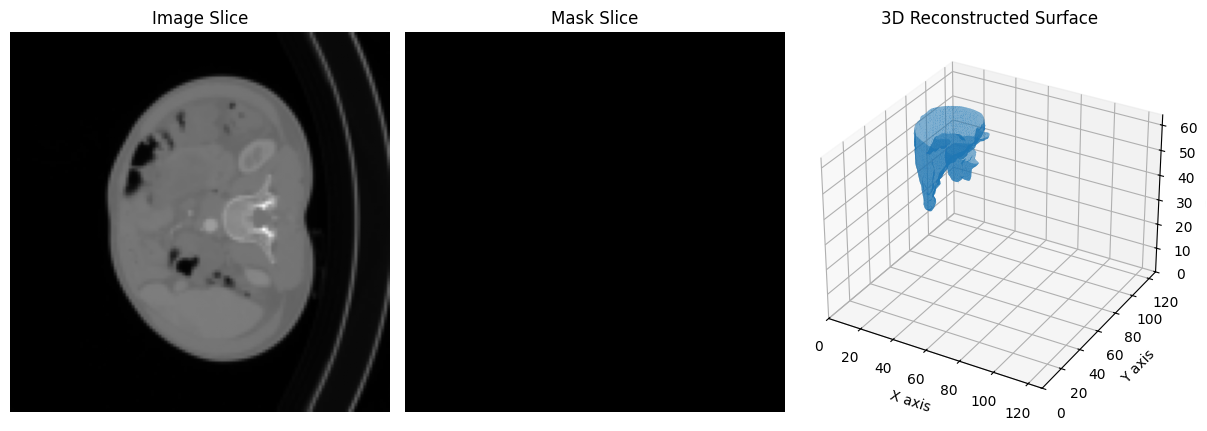

1/1 [==============================] - 0s 27ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_17.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 38ms/step
Calculated volume for Dliv

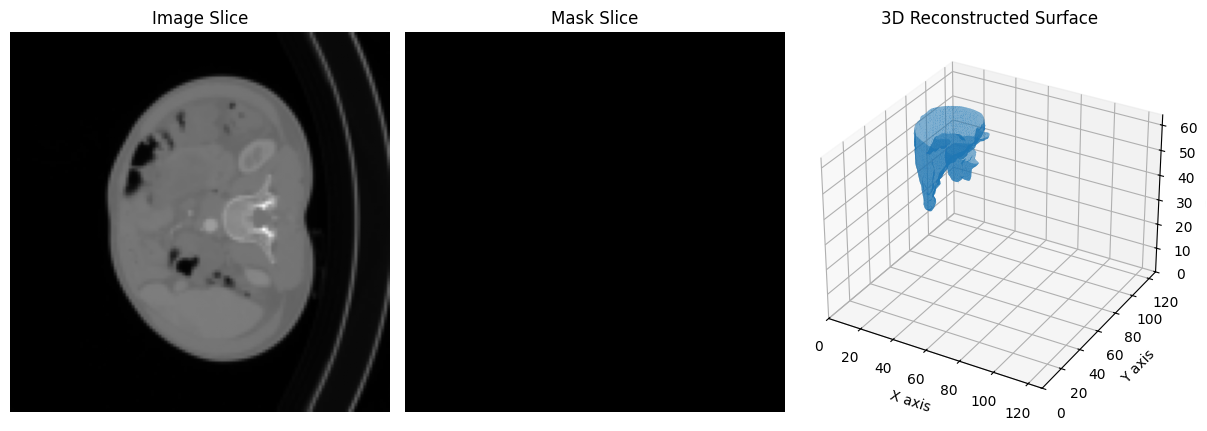

1/1 [==============================] - 0s 26ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_18.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 26ms/step
Calculated volume for Dliv

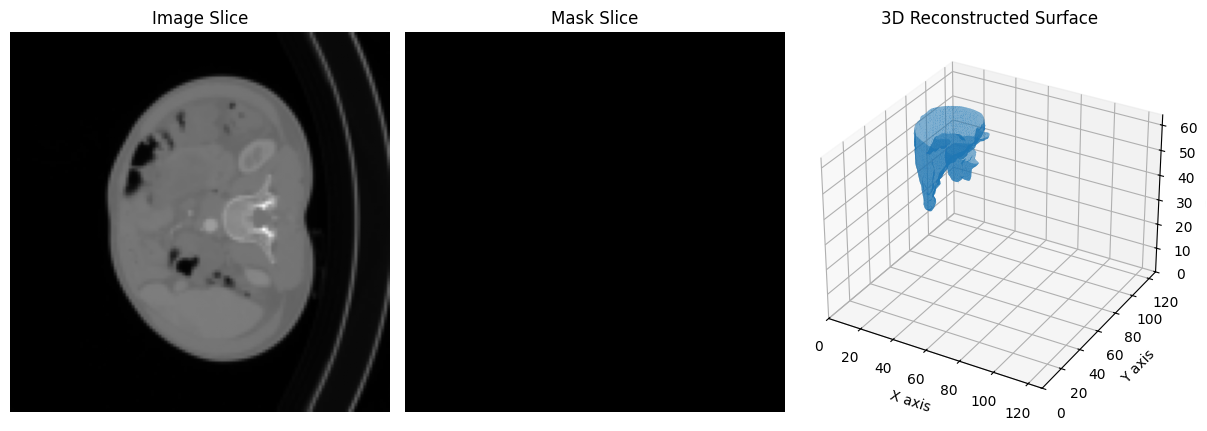

1/1 [==============================] - 0s 26ms/step
NIfTI file saved at /home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE/prediction_19.nii.gz
Processing file 1/20: Dliver18A.nii.gz
Processing file 2/20: Dliver4A.nii.gz
Processing file 3/20: Dliver10A.nii.gz
Processing file 4/20: Dliver15A.nii.gz
Processing file 5/20: Dliver17A.nii.gz
Processing file 6/20: Dliver16A.nii.gz
Processing file 7/20: Dliver5A.nii.gz
Processing file 8/20: Dliver12A.nii.gz
Processing file 9/20: Dliver7A.nii.gz
Processing file 10/20: Dliver14A.nii.gz
Processing file 11/20: Dliver8A.nii.gz
Processing file 12/20: Dliver2A.nii.gz
Processing file 13/20: Dliver11A.nii.gz
Processing file 14/20: Dliver20A.nii.gz
Processing file 15/20: Dliver6A.nii.gz
Processing file 16/20: Dliver1A.nii.gz
Processing file 17/20: Dliver9A.nii.gz
Processing file 18/20: Dliver3A.nii.gz
Processing file 19/20: Dliver19A.nii.gz
Processing file 20/20: Dliver13A.nii.gz
1/1 [==============================] - 0s 33ms/step
Calculated volume for Dliv

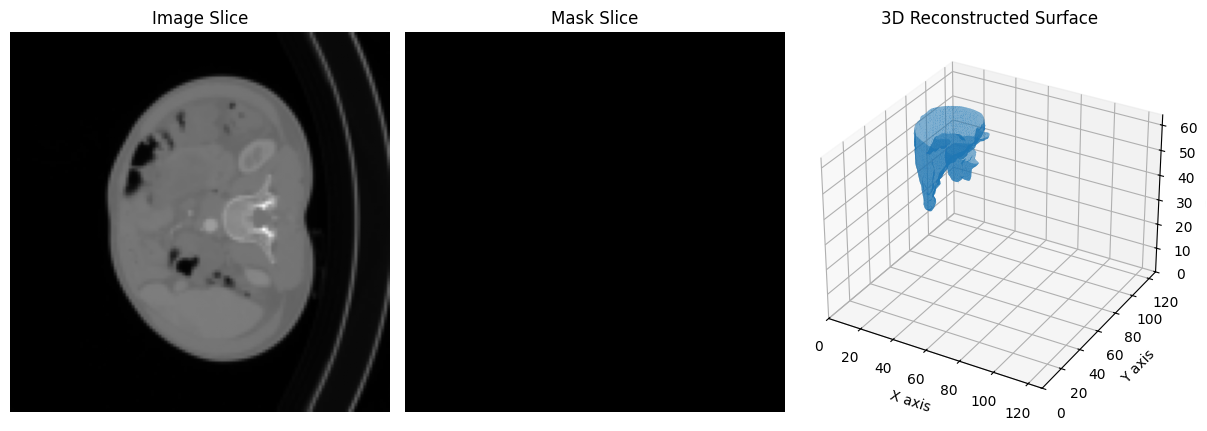

In [8]:
def save_as_nifti(data, affine, file_path):
    """
    Save data as a NIfTI file.
    
    Parameters:
    - data (numpy.ndarray): The 3D or 4D array to save.
    - affine (numpy.ndarray): Affine matrix for spatial orientation.
    - file_path (str): Output file path.
    """
    nifti_img = nib.Nifti1Image(data, affine)
    nib.save(nifti_img, file_path)
    print(f"NIfTI file saved at {file_path}")

def display_results_with_marching_cubes(model, file_list, data_path, mask_path, output_path, num_images=25):
    """
    Display and save results using marching cubes visualization and save NIfTI files.

    Parameters:
    - model: Trained model for predictions.
    - file_list (list): List of file names for testing.
    - data_path (str): Path to the input data.
    - mask_path (str): Path to ground truth masks (optional).
    - output_path (str): Path to save output NIfTI files.
    - num_images (int): Number of images to process.
    """
    target_shape = (128, 128, 64)  # Fixed shape for all volumes
    num_images = min(num_images, len(file_list))  # Ensure we do not exceed the number of files

    if not os.path.exists(output_path):
        os.makedirs(output_path)  # Create output directory if it doesn't exist

    for i, filename in enumerate(file_list[:num_images]):
        # Load the input image
        input_img_path = os.path.join(data_path, filename)
        input_img, affine, _ = load_nifti_memmap(input_img_path)

        # Resize to target shape if necessary
        if input_img.shape != target_shape:
            input_img = resize_volume(input_img, target_shape)

        # Make a prediction
        input_img = input_img[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
        prediction = model.predict(input_img)
        prediction = np.squeeze(prediction)  # Remove unnecessary dimensions

        # Save the prediction as a NIfTI file
        output_file_path = os.path.join(output_path, f"prediction_{i}.nii.gz")
        save_as_nifti(prediction, affine, output_file_path)
        

        for i in range(num_images):
            # Load image and mask
            image_file_path = os.path.join(data_path, file_list[i])
            mask_file_path = os.path.join(mask_path, file_list[i])
            
            print(f"Processing file {i+1}/{num_images}: {file_list[i]}")

        try:
            image = nib.load(image_file_path).get_fdata(dtype=np.float32)
            mask = nib.load(mask_file_path).get_fdata(dtype=np.float32)
            
            # Resize image and mask to expected shape
            image = resize_image(image, target_shape[:2])
            mask = resize_image(mask, target_shape[:2])
            
            # Pad or crop image and mask to match target depth
            image = pad_or_crop_volume(image, target_shape)
            mask = pad_or_crop_volume(mask, target_shape)
            
            # Preprocess image and mask
            image = image[..., np.newaxis]
            mask = mask[..., np.newaxis]

            # Get prediction
            prediction = model.predict(np.expand_dims(image, axis=0))[0, ..., 0]
            
            # Calculate the volume
            voxel_volume = np.prod(image.shape) / np.sum(mask > 0)  # Example volume calculation
            liver_volume = calculate_volume(mask, voxel_volume)
            print(f"Calculated volume for {file_list[i]}: {liver_volume:.2f} cubic units")

            # 3D Visualization using marching cubes
            verts, faces, _, _ = marching_cubes(mask[..., 0], level=0.5)
            fig = plt.figure(figsize=(12, 6))

            # Subplot 1: Original Data (image slice)
            ax1 = fig.add_subplot(131)
            ax1.imshow(image[:, :, target_shape[2] // 2, 0], cmap='gray')
            ax1.set_title("Image Slice")
            ax1.axis('off')

            # Subplot 2: Ground Truth Mask (slice)
            ax2 = fig.add_subplot(132)
            ax2.imshow(mask[:, :, target_shape[2] // 2, 0], cmap='gray')
            ax2.set_title("Mask Slice")
            ax2.axis('off')

            # Subplot 3: 3D Reconstructed Surface
            ax3 = fig.add_subplot(133, projection='3d')
            mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='none')
            ax3.add_collection3d(mesh)
            ax3.set_xlim(0, mask.shape[0])
            ax3.set_ylim(0, mask.shape[1])
            ax3.set_zlim(0, mask.shape[2])
            ax3.set_title("3D Reconstructed Surface")
            ax3.set_xlabel("X axis")
            ax3.set_ylabel("Y axis")
            ax3.set_zlabel("Z axis")

            plt.tight_layout()
            plt.show()
        
        except Exception as e:
            print(f"Error processing file {file_list[i]}: {e}")


        # Paths and model setup
data_path = r'/home/icmr/Downloads/niigz dicom/Arterial Phase'  
mask_path = r'/home/icmr/Downloads/niigz liver/Arterial Phase'  # Optional, only for comparison
output_path = '/home/icmr/Documents/LIVER_OUTPUT/ATRIAL_PHASE' 
 
# List of files to process
file_list = [f for f in os.listdir(data_path) if f.endswith('.nii.gz')]

# Call the function
display_results_with_marching_cubes(model, file_list, data_path, mask_path, output_path, num_images=25)

